In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2

In [2]:
pd.__version__

'1.1.1'

In [3]:
df_raw = pd.read_csv("../data/reviews.csv")

In [4]:
display(df_raw.head())

display(df_raw.describe())

print(df_raw.isnull().any().sum())

,listing_id,date
0,109,2011-08-15
1,109,2016-05-15
2,2708,2014-06-09
3,2708,2014-06-23
4,2708,2015-07-25


,listing_id
count,1.075393e+06
mean,1.639552e+07
std,1.145206e+07
min,1.090000e+02
25%,6.364732e+06
50%,1.554980e+07
75%,2.392072e+07
max,4.578991e+07


0


## Data Preprocessing

In [5]:
df = df_raw.groupby(["date"]).agg('count')

#set index to datetime
df.index = pd.to_datetime(df.index)

#frequency
df = df.asfreq('D', fill_value=0)

display(df.head())

,listing_id
date,
2009-05-26,1
2009-05-27,0
2009-05-28,0
2009-05-29,0
2009-05-30,0


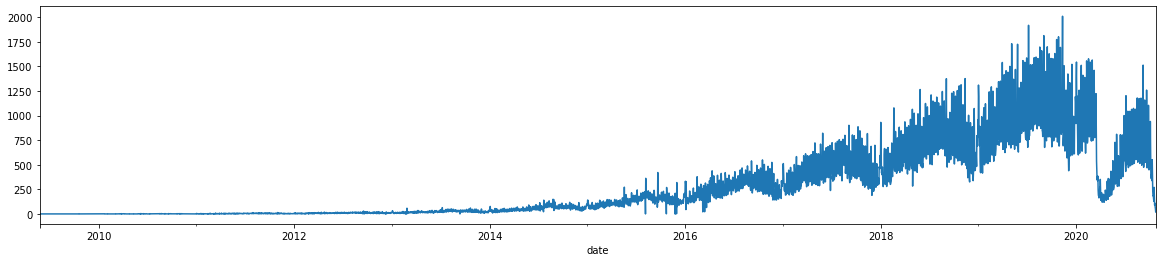

In [6]:
df.listing_id.plot(figsize=(20,4))
plt.show()

array([[<AxesSubplot:title={'center':'listing_id'}>]], dtype=object)

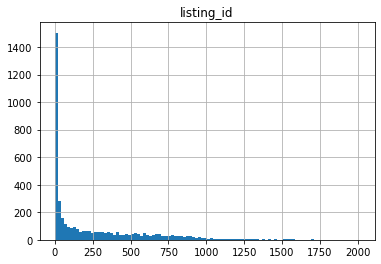

In [7]:
df.hist(bins=100)

<AxesSubplot:title={'center':'Residue'}, xlabel='date'>

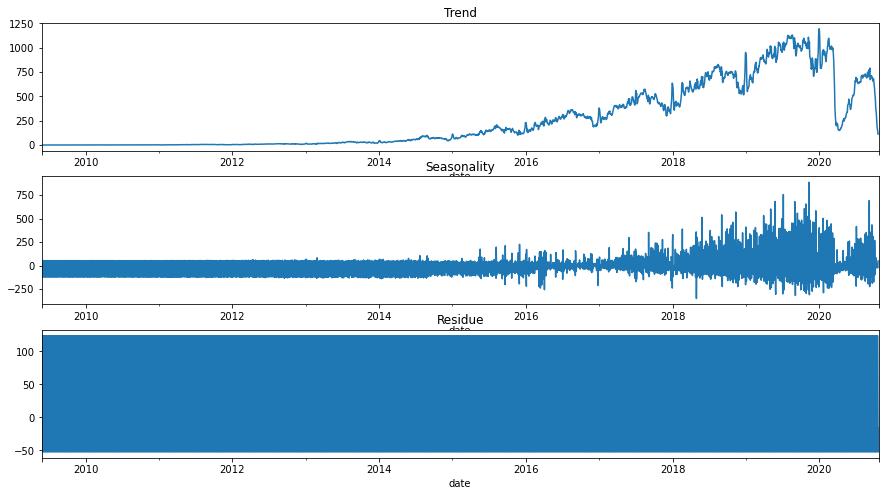

In [8]:
result = seasonal_decompose(df.listing_id, model="additive")

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
result.trend.plot(ax=ax1, title="Trend")
result.resid.plot(ax=ax2,  title="Seasonality")
result.seasonal.plot(ax=ax3,  title="Residue")

## Stationarity Test

In [9]:
sts.adfuller(df.listing_id)

(-2.0554804948006358,
 0.26278857620471785,
 30,
 4139,
 {'1%': -3.4319309036495986,
  '5%': -2.8622385564845723,
  '10%': -2.567141847950313},
 47214.91808477979)

P value > 0.05 shows that the time series is not stationary. Need to perform differencing to make it stationary.

## Perform time series differencing

* Transformation
    * Examples. Log, square root, etc.
    * We are going to look at log.
* Smoothing
    * Examples. Weekly average, monthly average, rolling averages.
    * We are going to look at weekly average.
* Differencing
    * Examples. First-order differencing.
    * We are going to look at first-order differencing.
* Polynomial Fitting
    * Examples. Fit a regression model.
* Decomposition

In [10]:
def plot_ts(dataframe, series1, series2):
    dataframe[series1].plot(figsize=(20,4),label=series1)
    dataframe[series2].plot(label=series2)
    plt.title(f"Time series plot of {series1} and {series2}")
    plt.legend()
    plt.show()

In [11]:
#log transform
df["ts_log"] = df["listing_id"].apply(lambda x: np.log(x))

#smoothing
df["ts_ma"] = df["listing_id"].rolling(7).mean()

#differencing
df["ts_diff"] = df["listing_id"].diff(1)
#differencing 2
df["ts_diff_2"] = df["ts_diff"].diff(1)

#log diff
df["ts_log_diff"] = df["ts_log"].diff(1)

#log ma
df["ts_log_ma"] = df["ts_log"].rolling(5).mean()

#log - ma
df["ts_log_diff_ma"] = df["ts_log"] - df["ts_log_ma"]

D:\anaconda3\envs\eunex\lib\site-packages\pandas\core\algorithms.py:1947: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [12]:
df.head()

,listing_id,ts_log,ts_ma,ts_diff,ts_diff_2,ts_log_diff,ts_log_ma,ts_log_diff_ma
date,,,,,,,,
2009-05-26,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-27,0,-inf,NaN,-1.0,NaN,-inf,NaN,NaN
2009-05-28,0,-inf,NaN,0.0,1.0,NaN,NaN,NaN
2009-05-29,0,-inf,NaN,0.0,0.0,NaN,NaN,NaN
2009-05-30,0,-inf,NaN,0.0,0.0,NaN,NaN,NaN


In [13]:
df_transformed = df.dropna()

df_transformed.head()

,listing_id,ts_log,ts_ma,ts_diff,ts_diff_2,ts_log_diff,ts_log_ma,ts_log_diff_ma
date,,,,,,,,
2010-05-03,1,0.0,0.714286,0.0,0.0,0.000000,0.000000,0.000000
2010-06-01,1,0.0,1.000000,-1.0,-2.0,-0.693147,0.277259,-0.277259
2010-08-30,1,0.0,1.285714,0.0,0.0,0.000000,0.277259,-0.277259
2010-08-31,1,0.0,1.142857,0.0,0.0,0.000000,0.138629,-0.138629
2010-09-01,1,0.0,1.285714,0.0,0.0,0.000000,0.000000,0.000000


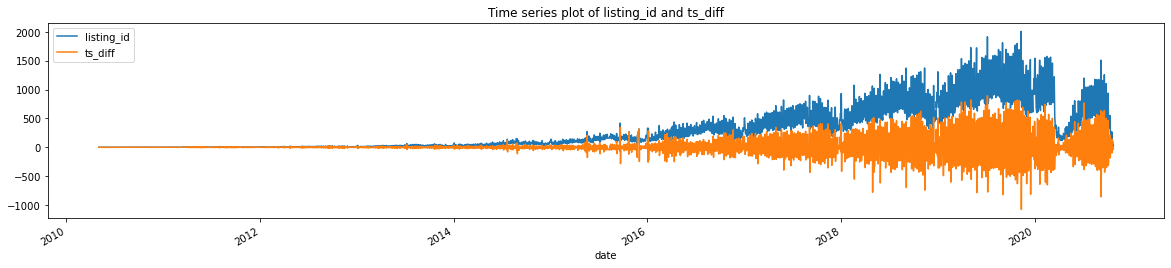

None

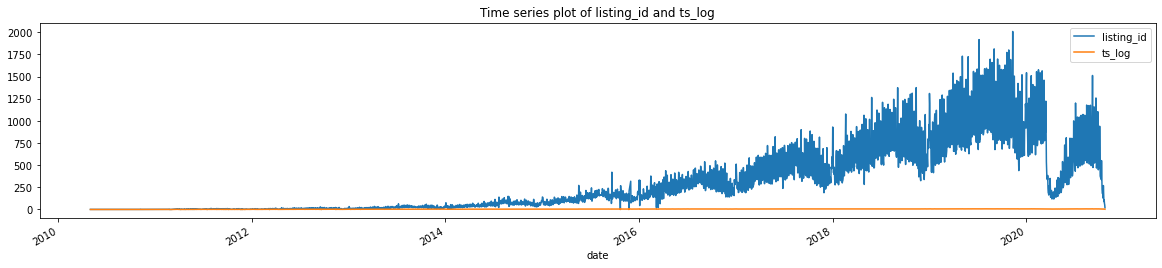

None

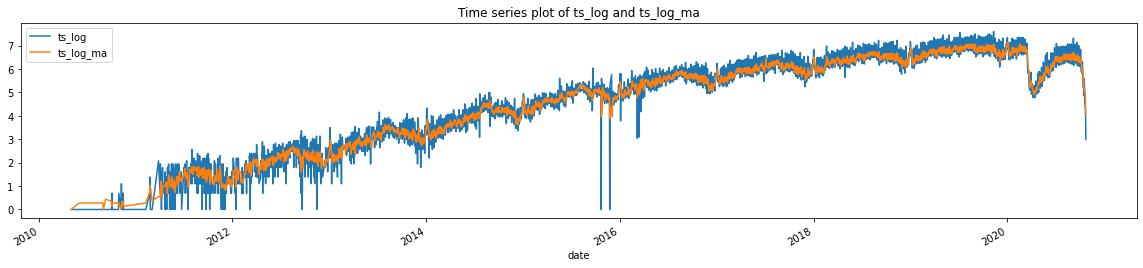

None

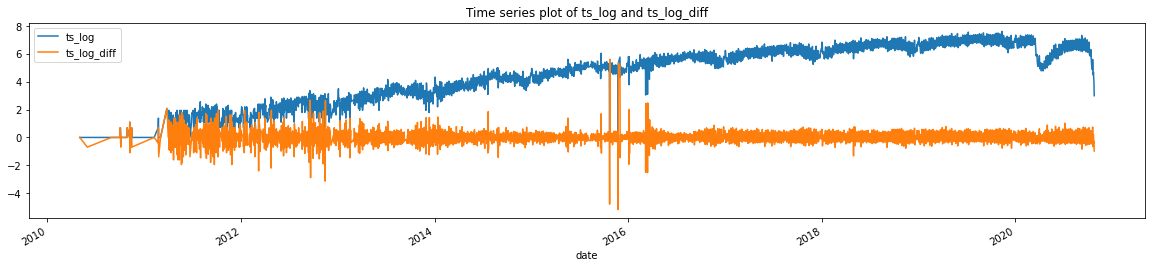

None

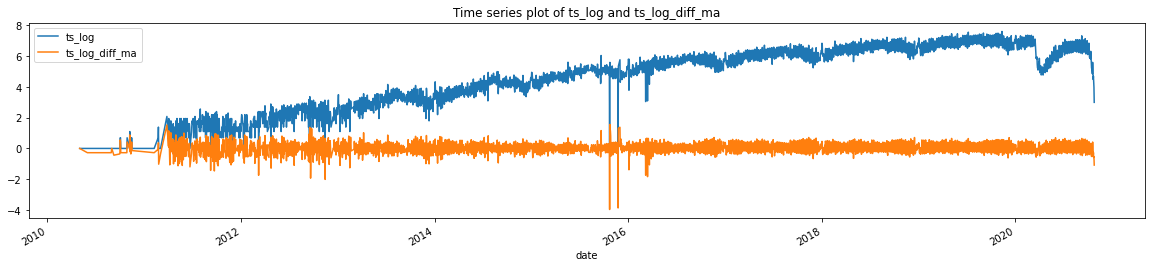

None

In [14]:
display(plot_ts(df_transformed, "listing_id", "ts_diff"))

display(plot_ts(df_transformed, "listing_id", "ts_log"))

display(plot_ts(df_transformed, "ts_log", "ts_log_ma"))

display(plot_ts(df_transformed, "ts_log", "ts_log_diff"))

display(plot_ts(df_transformed, "ts_log", "ts_log_diff_ma"))

In [15]:
print(f"Adfuller Testdropesullts for raw data: {sts.adfuller(df_transformed.listing_id)[1]}")
print(f"Adfuller Test Resullts for ts_diff: {sts.adfuller(df_transformed.ts_diff)[1]}")
print(f"Adfuller Test Resullts for ts_log_diff: {sts.adfuller(df_transformed.ts_log_diff)[1]}")
print(f"Adfuller Test Resullts for ts_log_diff_ma: {sts.adfuller(df_transformed.ts_log_diff_ma)[1]}")

Adfuller Testdropesullts for raw data: 0.28039179023030303
Adfuller Test Resullts for ts_diff: 2.636246749448487e-17
Adfuller Test Resullts for ts_log_diff: 4.491564196840976e-19
Adfuller Test Resullts for ts_log_diff_ma: 2.271059792226945e-19


## Decomposition

In [ ]:
result = seasonal_decompose(df_transformed.ts_log, period=365)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
result.trend.plot(ax=ax1, title="Trend")
result.resid.plot(ax=ax2,  title="Seasonality")
result.seasonal.plot(ax=ax3,  title="Residue")

## ACF and PACF analysis

In [ ]:
sgt.plot_acf(df_transformed.ts_log_diff, zero=False, lags=40)
plt.title("ACF Analysis")
plt.show()

In [ ]:
sgt.plot_pacf(df_transformed.ts_log_diff, zero=False, lags=40)
plt.title("PACF Analysis")
plt.show()

## ARIMA Modelling

## ARMA(7,6)

In [ ]:
data = df_transformed.ts_log_diff

arima_7_6 = ARIMA(data, order=(7,0,6))
result = arima_7_6.fit()
result.summary()

In [ ]:
result.resid.plot()
sgt.plot_acf(result.resid, zero=False, lags=40)
plt.show()


print(sts.adfuller(result.resid)[1])

## Model Fine Tuning

In [ ]:
def LLR_test(mod1, mod2, df=1):
    llf_mod1 = mod1.fit().llf
    llf_mod2 = mod2.fit().llf
    diff = (2*(llf_mod2- llf_mod1))
    p = chi2.sf(diff, df=df).round(3)
    return p

## Model (6,2)

In [ ]:
arma = dict()
for p in range(1,8):
    for q in range(1,7):
        data = df_transformed.ts_log_diff
        model = ARIMA(data, order=(p,0,q))
        arma[f"{p}_{q}"] = model
        result = model.fit()
        print(result.summary())

Models with significant coefficients are:
* ARMA(4,3)
* ARMA(4,5)
* ARMA(5,1)
* ARMA(5,2)
* ARMA(5,3)
* ARMA(6,2)
* ARMA(6,5)

In [ ]:
print(f"ARMA(4,3) \tLLF: {arma['4_3'].fit().llf} \tAIC:{arma['4_3'].fit().aic}")
print(f"ARMA(4,5) \tLLF: {arma['4_5'].fit().llf} \tAIC:{arma['4_5'].fit().aic}")

In [ ]:
print(f"ARMA(5,1) \tLLF: {arma['5_1'].fit().llf} \tAIC:{arma['5_1'].fit().aic}")
print(f"ARMA(5,2) \tLLF: {arma['5_2'].fit().llf} \tAIC:{arma['5_2'].fit().aic}")
print(f"ARMA(5,3) \tLLF: {arma['5_3'].fit().llf} \tAIC:{arma['5_3'].fit().aic}")

In [ ]:
print(f"ARMA(6,2) \tLLF: {arma['6_2'].fit().llf} \tAIC:{arma['6_2'].fit().aic}")
print(f"ARMA(6,5) \tLLF: {arma['6_5'].fit().llf} \tAIC:{arma['6_5'].fit().aic}")

In [ ]:
LLR_test(arma["4_5"], arma["6_5"], df=2)

We will choose arma(6,5) as our final model.

In [ ]:
result_arma_6_5 = arma["6_5"].fit()
result_arma_6_5.summary()

## Residual Analysis of ARMA(6,5)

In [ ]:
resid_arma_6_5 = result_arma_6_5.resid

In [ ]:
resid_arma_6_5.plot(figsize=(20,4))
plt.title("Residuals plot of ARMA(6,5)")
plt.show()

In [ ]:
sgt.plot_acf(resid_arma_6_5, zero=False, lags=40)
plt.title("ACF plot of residuals of ARMA(6,5)")
plt.show()

In [ ]:
sts.adfuller(resid_arma_6_5)

Residuals analysis shows that the residuals are stationary which fits the assumptions.

## Visualize results of ARMA(6_5) on log data

In [ ]:
df_transformed.ts_log_diff.plot(figsize=(20,4), label="Original Data", color='b')
result_arma_6_5.fittedvalues.plot(figsize=(20,4), label="ARMA (6,5)", color='r')
plt.legend()
plt.title('RMSE: %.4f'% np.sqrt(sum((result_arma_6_5.fittedvalues-df_transformed.ts_log_diff)**2)/len(df_transformed.ts_log_diff)))
plt.show()

## Prediction with FB Prophet

In [16]:
from fbprophet import Prophet
import pandas as pd

In [17]:
model = Prophet()

In [18]:
df

,listing_id,ts_log,ts_ma,ts_diff,ts_diff_2,ts_log_diff,ts_log_ma,ts_log_diff_ma
date,,,,,,,,
2009-05-26,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-27,0,-inf,NaN,-1.0,NaN,-inf,NaN,NaN
2009-05-28,0,-inf,NaN,0.0,1.0,NaN,NaN,NaN
2009-05-29,0,-inf,NaN,0.0,0.0,NaN,NaN,NaN
2009-05-30,0,-inf,NaN,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-10-20,89,4.488636,168.714286,-84.0,13.0,-0.664655,5.020603,-0.531967
2020-10-21,109,4.691348,158.000000,20.0,104.0,0.202712,4.956746,-0.265398
2020-10-22,70,4.248495,141.285714,-39.0,-59.0,-0.442853,4.836039,-0.587543


In [19]:
df_prophet = pd.DataFrame({'ds':df.index, 'y':df.listing_id})
df_prophet = df_prophet.reset_index()

In [20]:
df_prophet.drop(['date'], inplace=True ,axis=1)

In [21]:
df_prophet.head()

,ds,y
0,2009-05-26,1
1,2009-05-27,0
2,2009-05-28,0
3,2009-05-29,0
4,2009-05-30,0


In [22]:
model.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
future_dates = model.make_future_dataframe(periods=365)

In [26]:
prediction = model.predict(future_dates)

In [27]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-05-26,-11.082809,-241.454947,130.363666,-11.082809,-11.082809,-51.749344,-51.749344,-51.749344,-37.323495,-37.323495,-37.323495,-14.425849,-14.425849,-14.425849,0.0,0.0,0.0,-62.832153
1,2009-05-27,-11.062061,-270.144616,105.799776,-11.062061,-11.062061,-65.448254,-65.448254,-65.448254,-51.985192,-51.985192,-51.985192,-13.463062,-13.463062,-13.463062,0.0,0.0,0.0,-76.510316
2,2009-05-28,-11.041314,-259.755145,107.416525,-11.041314,-11.041314,-64.859221,-64.859221,-64.859221,-52.331600,-52.331600,-52.331600,-12.527621,-12.527621,-12.527621,0.0,0.0,0.0,-75.900535
3,2009-05-29,-11.020566,-217.087763,149.684004,-11.020566,-11.020566,-30.796406,-30.796406,-30.796406,-19.175663,-19.175663,-19.175663,-11.620743,-11.620743,-11.620743,0.0,0.0,0.0,-41.816972
4,2009-05-30,-10.999819,-227.040033,157.128928,-10.999819,-10.999819,-27.585460,-27.585460,-27.585460,-16.843420,-16.843420,-16.843420,-10.742040,-10.742040,-10.742040,0.0,0.0,0.0,-38.585278


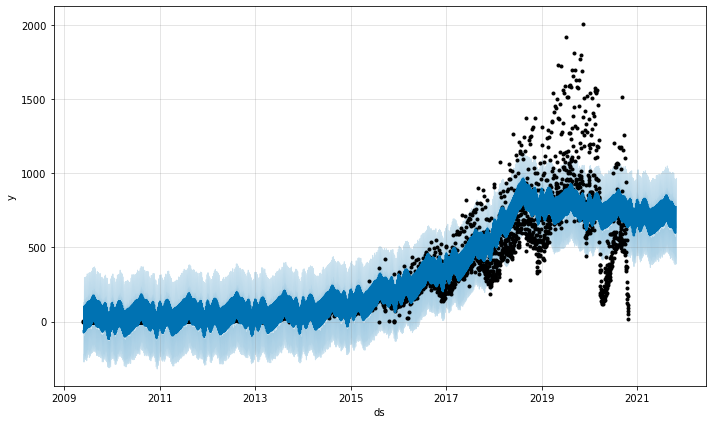

In [29]:
model.plot(prediction)
plt.show()

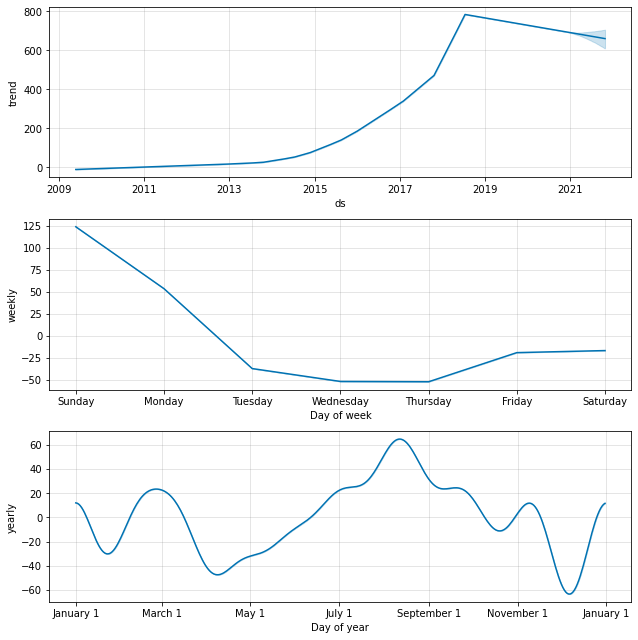

In [31]:
model.plot_components(prediction)
plt.show()

In [33]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model, horizon='365 days')
df_cv.head()

INFO:fbprophet:Making 15 forecasts with cutoffs between 2012-10-26 00:00:00 and 2019-10-25 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-27,11.527780,8.779355,14.086068,8,2012-10-26
1,2012-10-28,11.803499,8.963741,14.656940,8,2012-10-26
2,2012-10-29,13.554183,10.501120,16.281186,21,2012-10-26
3,2012-10-30,12.710851,9.885784,15.690100,17,2012-10-26
4,2012-10-31,11.800476,9.209547,14.702728,7,2012-10-26


In [34]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,36 days 12:00:00,22438.853697,149.796040,83.587611,0.230885,0.323583
1,37 days 00:00:00,22786.789185,150.952937,84.849185,0.236164,0.313757
2,37 days 12:00:00,22935.875141,151.445948,84.976500,0.231067,0.318099
3,38 days 00:00:00,23092.646804,151.962649,85.969276,0.231428,0.314214
4,38 days 12:00:00,22462.780358,149.875883,85.126541,0.228423,0.321755


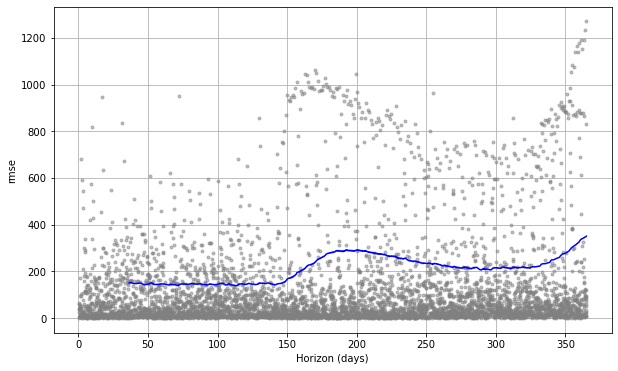

In [35]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')